<a href="https://colab.research.google.com/github/yaelsh66/DL-course/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Homework 1: ANN & KNN on SIFT Features**

Submitted by:
Yael Babichenko 036737062
Maria Alon Kutsaya 306561085

In [ ]:
# Libraries imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors
import time
from abc import ABC, abstractmethod
from collections import defaultdict
from abc import ABC, abstractmethod
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix



In [ ]:
def load_training_data():
  X = []         # list of SIFT descriptors
  y = []         # list of corresponding labels

  for filename in os.listdir():
    if filename.endswith("_1_sift_dataset.csv") and filename != "migdal_1_sift_dataset.csv":
      label = filename.split("_1")[0]   # e.g., "eiffel_tower"
      df = pd.read_csv(filename)
      features = normalizeFeatures(df.iloc[:, 5:133].values)

      X.append(features)
      y.extend([label] * len(features))  # same label for each SIFT

  X = np.vstack(X)
  y = np.array(y)
  return X, y


In [ ]:
# datasets
migdal_1 = pd.read_csv('migdal_1_sift_dataset.csv')
migdal_2 = pd.read_csv('migdal_2_sift_dataset.csv')

In [ ]:
# images
migdal_1_img = Image.open("migdal_1.JPG")
migdal_2_img = Image.open("migdal_2.JPG")

## 1. Data exploration:

### Migdal_1 dataset:

The raw data:

In [ ]:
# Separating the data colums to the sift descriptors and the extra data
extra_data_1 = migdal_1.iloc[:, :5]
extra_data_1.columns = ['Y', 'X', 'Scale', 'Angle', 'Response']
sift_descriptors_1 = migdal_1.iloc[:, 5:]


In [ ]:
# Displaying the raw data tables
display(migdal_1.head(3))

Y            X      Scale       Angle  Response  Feature_1  \
0  1080.289917  1871.340576   2.650851  265.588531  0.108878      133.0   
1   992.686340  1960.387939   2.606995  353.797394  0.077875       30.0   
2  1958.299438  2614.439209  17.619907  261.920410  0.076401        2.0   

   Feature_2  Feature_3  Feature_4  Feature_5  ...  Feature_119  Feature_120  \
0       26.0        0.0        1.0        1.0  ...         28.0         25.0   
1       23.0       31.0        1.0        0.0  ...         71.0         84.0   
2        1.0        5.0       10.0        5.0  ...         28.0         61.0   

   Feature_121  Feature_122  Feature_123  Feature_124  Feature_125  \
0          4.0          3.0          2.0          2.0         46.0   
1          4.0         97.0         60.0          0.0          0.0   
2          2.0          1.0          9.0         14.0         71.0   

   Feature_126  Feature_127  Feature_128  
0          4.0          0.0          2.0  
1         22.0         10.0          1.0  
2         83.0          9.0          3.0  

[3 rows x 133 columns]

We can see here the columns: Y, X, Scale, Angle, Response and all SIFT features

In [ ]:
display(migdal_1.sample(15))

Y            X      Scale       Angle  Response  Feature_1  \
14    713.825684  1827.159912   2.962687    0.952110  0.104573        8.0   
350  1397.529907  1094.183105   6.701230   76.560654  0.073478       28.0   
532  1226.203125  2950.858398   4.170854   96.978798  0.069654       13.0   
4    1375.478271  2610.739746   2.060762  218.360001  0.080922       70.0   
312   964.158203  1896.413574   2.087876  226.038040  0.099150        1.0   
697  1299.789062  1700.822388   3.862056  348.287750  0.071156        1.0   
1     992.686340  1960.387939   2.606995  353.797394  0.077875       30.0   
17   1067.326782  2055.509277  10.698768  256.186035  0.078627        8.0   
509   627.274231  1611.448730   2.557788  172.936386  0.080042        0.0   
227  1566.584961  2137.099121   3.897980    0.071983  0.074175        2.0   
110  1146.346191  1311.473999   2.176903  258.946686  0.086242       18.0   
850   911.045715  2067.917236   4.093552  183.989105  0.068067        0.0   
426  2055.552734  1851.746948   2.056011   85.037598  0.082025       14.0   
510   627.274231  1611.448730   2.557788    2.337608  0.080042       13.0   
89   1584.369873  2581.260742  41.243088   96.686691  0.073269       97.0   

     Feature_2  Feature_3  Feature_4  Feature_5  ...  Feature_119  \
14         6.0        2.0        1.0        0.0  ...         30.0   
350       12.0       11.0        3.0        6.0  ...          0.0   
532        6.0        5.0        4.0      130.0  ...          3.0   
4        131.0        8.0       11.0        7.0  ...          6.0   
312        2.0        4.0       49.0       21.0  ...          5.0   
697       39.0       47.0        1.0        0.0  ...          0.0   
1         23.0       31.0        1.0        0.0  ...         71.0   
17         5.0       20.0       10.0        6.0  ...          1.0   
509        0.0        0.0        2.0        5.0  ...          0.0   
227        2.0        4.0        9.0       42.0  ...         11.0   
110       30.0       44.0       13.0        4.0  ...          5.0   
850        0.0        0.0        1.0       34.0  ...          1.0   
426        1.0        0.0        1.0       57.0  ...        123.0   
510        7.0        1.0        0.0       66.0  ...         21.0   
89        77.0        0.0        0.0        0.0  ...          0.0   

     Feature_120  Feature_121  Feature_122  Feature_123  Feature_124  \
14          15.0          3.0         18.0         64.0         16.0   
350         53.0        140.0         15.0          8.0         19.0   
532          5.0         85.0         18.0          0.0          0.0   
4           13.0          7.0          1.0          1.0          7.0   
312         13.0          8.0          5.0          3.0          2.0   
697         49.0          6.0          3.0          2.0         49.0   
1           84.0          4.0         97.0         60.0          0.0   
17           4.0         15.0          0.0          0.0          9.0   
509         53.0         18.0          0.0          0.0          1.0   
227         16.0          1.0          4.0         13.0         19.0   
110          4.0         84.0          7.0          2.0          2.0   
850          5.0         40.0          7.0          0.0         10.0   
426        123.0          0.0          1.0          5.0          1.0   
510         18.0          7.0          8.0          9.0          3.0   
89           0.0        115.0         90.0          3.0          0.0   

     Feature_125  Feature_126  Feature_127  Feature_128  
14           1.0          2.0          5.0          2.0  
350          9.0          1.0          0.0         35.0  
532          8.0         13.0          1.0          2.0  
4            2.0          0.0          0.0          8.0  
312          0.0          0.0          1.0         13.0  
697         86.0          0.0          0.0          1.0  
1            0.0         22.0         10.0          1.0  
17         136.0         12.0          1.0          2.0  
50

In [ ]:
display(migdal_1.describe())

Y            X        Scale        Angle     Response  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean   1471.882879  2052.321515     6.415403   183.120681     0.075678   
std     572.609704   819.846173     9.453957   100.941190     0.008718   
min      33.511398    32.151867     1.802956     0.071983     0.066234   
25%     962.038513  1459.857513     2.508220    91.655151     0.069203   
50%    1473.780640  1924.157227     3.352797   181.275871     0.073077   
75%    1918.500000  2597.100159     5.483221   267.870743     0.079520   
max    2980.874512  3960.908936   107.784523   359.909546     0.114931   

         Feature_1    Feature_2    Feature_3    Feature_4    Feature_5  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     22.510000    17.636000    19.375000    13.403000    19.254000  ...   
std      32.354795    26.402246    31.183373    22.650378    30.198202  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       1.000000     1.000000     1.000000     1.000000     1.000000  ...   
50%       9.000000     7.000000     5.000000     5.000000     5.500000  ...   
75%      29.000000    21.000000    23.000000    15.000000    24.000000  ...   
max     159.000000   154.000000   155.000000   142.000000   160.000000  ...   

       Feature_119  Feature_120  Feature_121  Feature_122  Feature_123  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     17.336000    25.769000    21.548000    15.811000    17.140000   
std      26.722635    30.569824    28.635322    25.579163    31.080483   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     4.000000     2.000000     1.000000     0.000000   
50%       6.000000    14.000000    10.000000     5.000000     3.000000   
75%      23.000000    38.000000    30.000000    18.000000    16.000000   
max     138.000000   152.000000   151.000000   168.000000   162.000000   

       Feature_124  Feature_125  Feature_126  Feature_127  Feature_128  
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.00000  
mean     13.055000    22.279000    12.343000    11.317000     11.22400  
std      22.105217    34.052999    22.558507    23.081752     19.85679  
min       0.000000     0.000000     0.000000     0.000000      0.00000  
25%       1.000000     1.000000     0.000000     0.000000      1.00000  
50%       4.000000     6.000000     3.000000     2.000000      3.00000  
75%      14.000000    27.000000    13.000000    10.000000     12.00000  
max     132.000000   149.000000   158.000000   138.000000    134.00000  

[8 rows x 133 columns]

We can see the range (min max) for each parameter

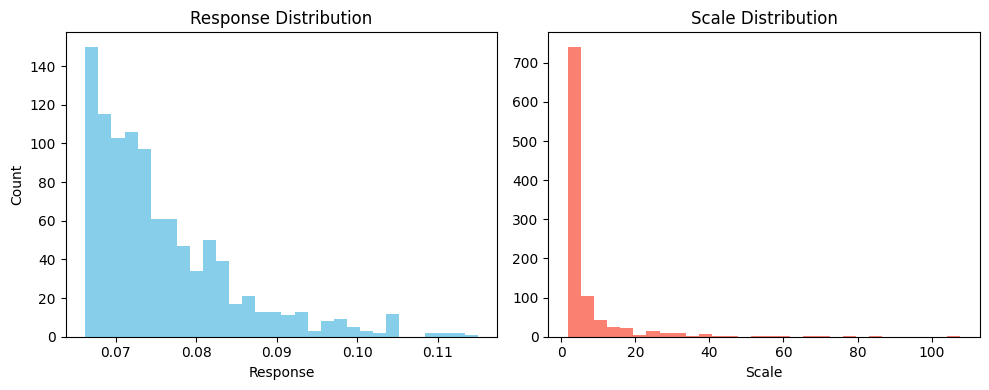

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(extra_data_1['Response'], bins=30, color='skyblue')
plt.title("Response Distribution")
plt.xlabel("Response")
plt.ylabel("Count")

# Scale
plt.subplot(1, 2, 2)
plt.hist(extra_data_1['Scale'], bins=30, color='salmon')
plt.title("Scale Distribution")
plt.xlabel("Scale")

plt.tight_layout()
plt.show()

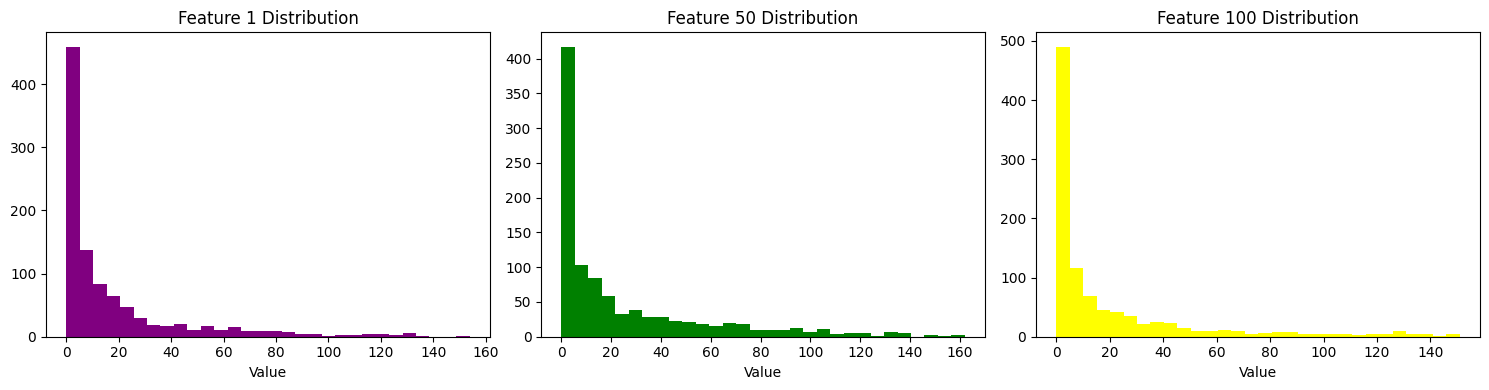

In [ ]:
plt.figure(figsize=(15, 4))

# One of the SIFT features (e.g., first descriptor dimension)
plt.subplot(1, 3, 1)
plt.hist(sift_descriptors_1.iloc[:, 1], bins=30, color='purple')
plt.title("Feature 1 Distribution")
plt.xlabel("Value")

# One of the SIFT features (e.g., first descriptor dimension)
plt.subplot(1, 3, 2)
plt.hist(sift_descriptors_1.iloc[:, 50], bins=30, color='green')
plt.title("Feature 50 Distribution")
plt.xlabel("Value")

# One of the SIFT features (e.g., first descriptor dimension)
plt.subplot(1, 3, 3)
plt.hist(sift_descriptors_1.iloc[:, 100], bins=30, color='yellow')
plt.title("Feature 100 Distribution")
plt.xlabel("Value")

plt.tight_layout()
plt.show()

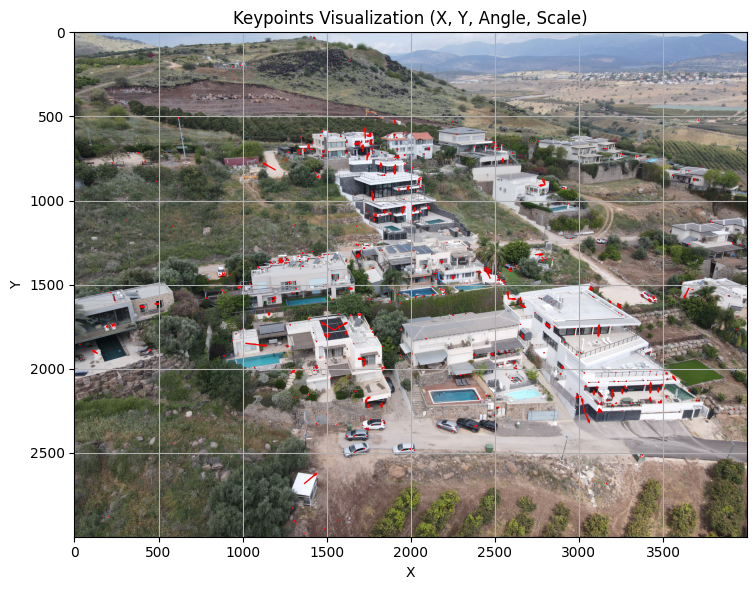

In [ ]:
x = extra_data_1['X'].values
y = extra_data_1['Y'].values
scale = extra_data_1['Scale'].values
angle = extra_data_1['Angle'].values

u = np.cos(np.deg2rad(angle)) * scale
v = np.sin(np.deg2rad(angle)) * scale

plt.figure(figsize=(8, 6))
plt.quiver(x, y, u, -v, color='red', angles='xy', scale_units='xy', scale = 0.8, width=0.002, headwidth=2, headlength=2)
plt.title("Keypoints Visualization (X, Y, Angle, Scale)")
plt.gca().invert_yaxis()
img = np.array(migdal_1_img)
plt.imshow(img)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Part A: Model Implementation

### KNN

In [ ]:
# Normalize the data points
def normalizeFeatures(features):
  norm = np.linalg.norm(features, axis=1, keepdims=True)
  normalized_features = features / (norm + 1e-8)
  return normalized_features

# Calculate distance by matrix multiply
def distance(a, b):
  a_sq = np.sum(a**2, axis=1).reshape(1, -1)
  b_sq = np.sum(b**2, axis=1).reshape(-1, 1)
  dot = b @ a.T
  distance = b_sq + a_sq - 2 * dot
  return distance

def ratioTest(indices, distances, threshold=0.6):

  if distances.shape[1] < 2:
    # Return all indices as -1 to indicate no matches
    return np.full_like(indices, -1)

  # ratio test
  ratios = distances[:, 0] / (distances[:, 1] + 1e-8)
  filtered_indices = indices.copy()
  for i in range(len(ratios)):
    if ratios[i] >= threshold:
      filtered_indices[i, 0] = -1  # Reject match
  return filtered_indices



In [ ]:
# k = number of kneighbors
# df_1  = train data
# df_2 = test data
# The function claculates the distance between each data point in df_2 the every data point in df_1, returns the closest k kneighbors.
def knn(k, df_1, df_2):

  normalized_features_1 = normalizeFeatures(df_1.iloc[:, 5:].values)
  normalized_features_2 = normalizeFeatures(df_2.iloc[:, 5:].values)

  #Distance calculation
  dist = distance(normalized_features_1, normalized_features_2)

  #sort by distance
  indices = np.argsort(dist, axis=1)[:, :k]
  #Distance for k closest neibors
  distances = np.take_along_axis(dist, indices, axis=1)

  return indices, distances






### Abstract ANN Class

In [ ]:
class ANNBase(ABC):

  @abstractmethod
  def fit(self, data):
      """Train the model with data"""
      pass

  @abstractmethod
  def kneighbors(self, query, k=1):
      """Return k nearest neighbors for the given query"""
      pass



### Two ANN models inheriting from the abstract class

In [ ]:
# TreeNode - Describe a tree node
class KDTreeNode:
  def __init__(self, axis=None, value=None, left=None, right=None, indices=None):
    self.axis = axis        # Dimension to split on
    self.value = value      # Split threshold (median value)
    self.left = left        # Left child node
    self.right = right      # Right child node
    self.indices = indices  # List of point indices (if leaf node)


class RKDT_ANN(ANNBase):
  def __init__(self, N0=10, L0=5):
    self.N0 = N0             # Max points per leaf
    self.L0 = L0             # Number of KD-Trees
    self.trees = []          # List of tree
    self.data = None         # Dataset

  def fit(self, data):

    self.data = data
    self.labels = None              # This will be set externally after fit
    indices = np.arange(len(data))  # Index array for training samples
    self.trees = []
    # Build the trees
    for _ in range(self.L0):
      tree = self._build_tree(indices)
      self.trees.append(tree)

  # indices = Data points index array
  def _build_tree(self, indices):

    # If the number of data points is less than the maximum points per leaf, create a leaf node with those data points.
    if len(indices) <= self.N0:
      return KDTreeNode(indices=indices)  # Create leaf node

    # random dimension
    D = self.data.shape[1]
    axis = np.random.randint(0, D)

    # Compute median in that axis among current points
    # Values = Take the 'axis' column from the remaining data points
    values = self.data[indices, axis]
    median = np.median(values)

    # Split points into left and right branches
    left_indices = indices[values <= median]
    right_indices = indices[values > median]

    # Handle degenerate case (all values identical)
    if len(left_indices) == 0 or len(right_indices) == 0:
      return KDTreeNode(indices=indices)

    # Recursively build left and right subtrees
    left = self._build_tree(left_indices)
    right = self._build_tree(right_indices)

    return KDTreeNode(axis=axis, value=median, left=left, right=right)

  def kneighbors(self, query, k):

    # Check if single or multy query (used in return dim calculation)
    is_single_query = False
    if query.ndim == 1:
      query = query.reshape(1, -1)
      is_single_query = True

    all_indices = []
    all_distances = []

    for q in query:
      # Set of kneighbors canidates (removes duplicates)
      candidates = set()
      for tree in self.trees:
        self._search_tree(tree, q, candidates)

      # Change the set back to a list to keep order
      candidate_list = list(candidates)
      candidate_vectors = self.data[candidate_list]

      # case with no candidates, set indices to -1 and distances to infinity
      if len(candidate_list) == 0:
        all_indices.append(np.full((k,), -1))
        all_distances.append(np.full((k,), np.inf))
        continue

      dists = np.sum((candidate_vectors - q) ** 2, axis=1)
      nearest_idx = np.argsort(dists)[:min(k, len(dists))]

      # Pad with -1 if not enough neighbors found
      num_found = len(nearest_idx)
      if num_found < k:
        padding = np.full(k - num_found, -1, dtype=int)
        nearest_idx = np.concatenate([nearest_idx, padding])


      all_indices.append(np.array(candidate_list)[nearest_idx])

      # padding for distances
      if num_found < k:
        dist_padding = np.full(k - num_found, np.inf)
        nearest_dists = dists[nearest_idx[:num_found]]  # Distances for found neighbors
        nearest_dists = np.concatenate([nearest_dists, dist_padding])
      else:
        nearest_dists = dists[nearest_idx]

      all_distances.append(nearest_dists)

    indices = np.vstack(all_indices)
    distances = np.vstack(all_distances)

    if is_single_query:
      return indices[0], distances[0]
    return indices, distances

  def _search_tree(self, node, query, candidates):

    if node.indices is not None:
      candidates.update(node.indices)
      return

    axis = node.axis
    if query[axis] <= node.value:
      self._search_tree(node.left, query, candidates)
    else:
      self._search_tree(node.right, query, candidates)

  def predict(self, test_features, k, distance_threshold=None, confidence_cutoff=None):
    predictions = []

    for q in test_features:
      indices, dists = self.kneighbors(q, k=k)

      # Skip invalid match if too far or empty
      if indices[0] == -1:
        continue

      if distance_threshold is not None and dists[0] > distance_threshold:
        continue

      # Majority vote among k neighbors
      neighbor_labels = self.labels[indices[indices != -1]]
      if len(neighbor_labels) == 0:
        continue

      if k == 1:
        predictions.append(neighbor_labels[0])
      else:
        top_label = Counter(neighbor_labels).most_common(1)[0][0]
        predictions.append(top_label)

    # Handle empty prediction case
    if not predictions:
      return "No matching landmark found", 0.0

    final_label = Counter(predictions).most_common(1)[0][0]
    confidence = predictions.count(final_label) / len(predictions)

    if confidence < confidence_cutoff:
      return "No matching landmark found", confidence

    return final_label, confidence

In [ ]:
class LSH_ANN(ANNBase):
  def __init__(self, K=10, L=5):
    self.K = K                  # Number of bits per hash code
    self.L = L                  # Number of hash tables
    self.hash_tables = []       # List of L hash tables (dicts)
    self.feature_indices = []   # List of L arrays of chosen feature indices
    self.thresholds = []        # List of L arrays of thresholds per feature
    self.data = None            # Original training data

  def fit(self, X):

    self.data = X
    self.labels = None
    N, D = X.shape             # N points, D features
    self.hash_tables = []
    self.feature_indices = []
    self.thresholds = []

    for l in range(self.L):
      hash_table = defaultdict(list)

      # Pick K random features (dimensions)
      chosen_features = np.random.choice(D, size=self.K, replace=False)

      # Pick a random threshold per chosen feature between its min and max
      thresholds = []
      for feat_idx in chosen_features:
        feat_values = X[:, feat_idx]
        min_val = feat_values.min()
        max_val = feat_values.max()
        thresh = np.random.uniform(min_val, max_val)
        thresholds.append(thresh)

      # Convert to numpy arrays for indexing
      thresholds = np.array(thresholds)

      # Store for current hash table
      self.feature_indices.append(chosen_features)
      self.thresholds.append(thresholds)
      self.hash_tables.append(hash_table)

    # Now hash every point into each hash table
    for i, x in enumerate(X):
      for l in range(self.L):
        bits = []
        for feat_idx, thresh in zip(self.feature_indices[l], self.thresholds[l]):
          bit = 1 if x[feat_idx] > thresh else 0
          bits.append(bit)
        hash_code = tuple(bits)           # Make bits hashable
        self.hash_tables[l][hash_code].append(i)

  def kneighbors(self, query, k):
    # Ensure query is 2D (support single or batch queries)
    is_single_query = False
    if query.ndim == 1:
      query = query.reshape(1, -1)
      is_single_query = True

    all_indices = []
    all_distances = []

    for q in query:
      candidate_set = set()  # To avoid duplicates

      # Hash the query into each table
      for l in range(self.L):
        features = self.feature_indices[l]
        thresholds = self.thresholds[l]

        bits = []
        for feat_idx, thresh in zip(features, thresholds):
          bit = 1 if q[feat_idx] > thresh else 0
          bits.append(bit)

        hash_code = tuple(bits)
        candidates = self.hash_tables[l].get(hash_code, [])

        # Add to overall candidate set
        candidate_set.update(candidates)

      # If no candidates found, return -1 and infinity for distance
      if not candidate_set:
        all_indices.append(np.full((k,), -1))
        all_distances.append(np.full((k,), np.inf))
        continue



      # Compute distances to all candidates
      candidate_list = list(candidate_set)

      candidate_vectors = self.data[candidate_list]

      # Euclidean (squared) distances
      dists = np.sum((candidate_vectors - q) ** 2, axis=1)
      nearest_idx = np.argsort(dists)[:min(k, len(dists))]

      # Pad with -1 if not enough neighbors found
      num_found = len(nearest_idx)
      if num_found < k:
        padding = np.full(k - num_found, -1, dtype=int)
        nearest_idx = np.concatenate([nearest_idx, padding])


      all_indices.append(np.array(candidate_list)[nearest_idx])

      # Similar padding for distances
      if num_found < k:
        dist_padding = np.full(k - num_found, np.inf)
        nearest_dists = dists[nearest_idx[:num_found]]  # Distances for found neighbors
        nearest_dists = np.concatenate([nearest_dists, dist_padding])
      else:
        nearest_dists = dists[nearest_idx]

      all_distances.append(nearest_dists)


    indices = np.vstack(all_indices)
    distances = np.vstack(all_distances)

    if is_single_query:
      return indices[0], distances[0]
    return indices, distances


  def predict(self, test_features, k=1, distance_threshold=None, confidence_cutoff = 0.1, min_votes=10):
    predictions = []

    for q in test_features:
      indices, dists = self.kneighbors(q, k=k)

      indices = np.array(indices).flatten()
      dists = np.array(dists).flatten()

      # Skip invalid or distant matches
      if indices[0] == -1 or (distance_threshold is not None and dists[0] > distance_threshold):
        continue

      # Get labels for valid neighbor indices
      valid = indices != -1
      neighbor_labels = self.labels[indices[valid]]

      if len(neighbor_labels) == 0:
        continue

      if k == 1:
        predictions.append(neighbor_labels[0])
      else:
        top_label = Counter(neighbor_labels).most_common(1)[0][0]
        predictions.append(top_label)

    # Handle no predictions
    if len(predictions) < min_votes:
      return "No matching landmark found", 0.0

    final_label = Counter(predictions).most_common(1)[0][0]
    confidence = predictions.count(final_label) / len(predictions)

    if confidence < confidence_cutoff:
      return "No matching landmark found", confidence

    return final_label, confidence




##Part B: KNN Nearest Neighbor Search

In [ ]:
def siftKNN(df_1, df_2, img_1, img_2, threshold = 0.8):
  start_knn = time.time()
  indices1, distances1 = knn(1, df_1, df_2)
  end_knn = time.time()
  runtime = end_knn - start_knn

  indices2, distances2 = knn(2, df_1, df_2)

  filtered_indices = ratioTest(indices2, distances2, threshold)

  visualizeSIFT(df_1, df_2, img_1, img_2, filtered_indices, distances2, top_k=10)

  return runtime, indices1, distances1


In [ ]:
def visualizeSIFT(df_1, df_2, img1, img2, filtered_indices, distances, top_k=10):
    # Load the images
    img1 = img1.convert("RGB")
    img2 = img2.convert("RGB")

    # Combine images side by side
    w1, h1 = img1.size
    w2, h2 = img2.size
    combined_width = w1 + w2
    combined_height = max(h1, h2)

    combined_img = Image.new("RGB", (combined_width, combined_height))
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (w1, 0))

    draw = ImageDraw.Draw(combined_img)

    # Collect valid matches (indices and distances)
    matches = []
    for i in range(len(filtered_indices)):
        match_idx = filtered_indices[i, 0]
        if match_idx != -1:
            matches.append((i, match_idx, distances[i, 0]))

    # Sort matches by distance (lowest first) and take top_k
    matches.sort(key=lambda x: x[2])
    matches = matches[:top_k]

    # Print match info
    print(f"\nTop {top_k} matches:")
    color = ["green", "red", "blue", "yellow", "pink", "brown", "black", "purple", "orange", "salmon"]

    for rank, (query_idx, train_idx, dist) in enumerate(matches):
        x1 = df_1.iloc[train_idx]["X"]
        y1 = df_1.iloc[train_idx]["Y"]
        x2 = df_2.iloc[query_idx]["X"]
        y2 = df_2.iloc[query_idx]["Y"]
        print(f"{rank + 1}. Distance: {dist:.4f}")
        print(f"    Image 1 (train): X={x1:.2f}, Y={y1:.2f}")
        print(f"    Image 2 (query): X={x2:.2f}, Y={y2:.2f}")

        # Draw the line
        draw.line([(x1, y1), (x2 + w1, y2)], fill=color[rank], width=15)



    plt.figure(figsize=(12, 8))
    plt.imshow(combined_img)
    plt.axis("off")
    plt.title("Top 10 SIFT Matches (Passing Ratio Test)")
    plt.show()


For threshold = 0.8:


Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0230
    Image 1 (train): X=3118.62, Y=2080.04
    Image 2 (query): X=2297.29, Y=2269.02
5. Distance: 0.0240
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1618.59, Y=1771.76
6. Distance: 0.0256
    Image 1 (train): X=1871.34, Y=1080.29
    Image 2 (query): X=2020.56, Y=1069.02
7. Distance: 0.0311
    Image 1 (train): X=1572.62, Y=1748.17
    Image 2 (query): X=303.00, Y=2339.72
8. Distance: 0.0356
    Image 1 (train): X=1903.94, Y=610.04
    Image 2 (query): X=2352.27, Y=609.78
9. Distance: 0.0416
    Image 1 (train): X=1572.62, Y=1748.17
    Image 2 (query): X=303.00, Y=2339.72
10. Distance: 0.0427
    Image 1 (train): X=1771.80, Y=

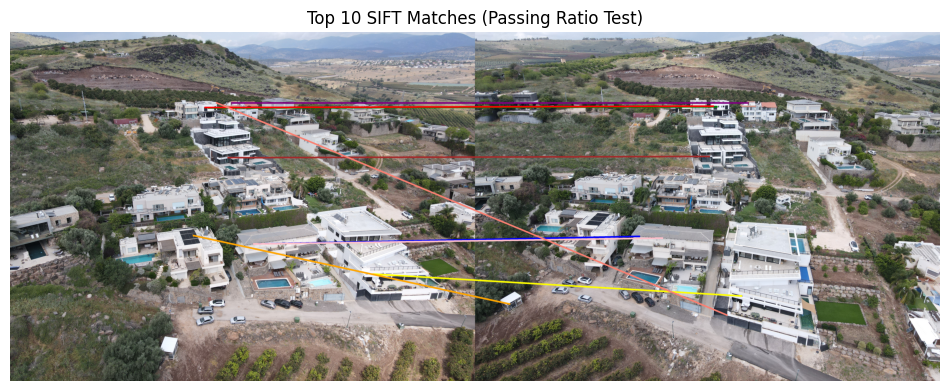

KNN distance calculations runtime: 0.079 seconds


In [ ]:
knn_time, knn_indices, knn_distances = siftKNN(migdal_1, migdal_2, migdal_1_img, migdal_2_img, threshold = 0.8)
print(f"KNN distance calculations runtime: {knn_time:.3f} seconds")

For threshold = 0.6:


Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0240
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1618.59, Y=1771.76
5. Distance: 0.0256
    Image 1 (train): X=1871.34, Y=1080.29
    Image 2 (query): X=2020.56, Y=1069.02
6. Distance: 0.0356
    Image 1 (train): X=1903.94, Y=610.04
    Image 2 (query): X=2352.27, Y=609.78
7. Distance: 0.0455
    Image 1 (train): X=1984.05, Y=926.87
    Image 2 (query): X=1803.07, Y=670.62
8. Distance: 0.0526
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
9. Distance: 0.0534
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
10. Distance: 0.0566
    Image 1 (train): X=2989.54, Y=

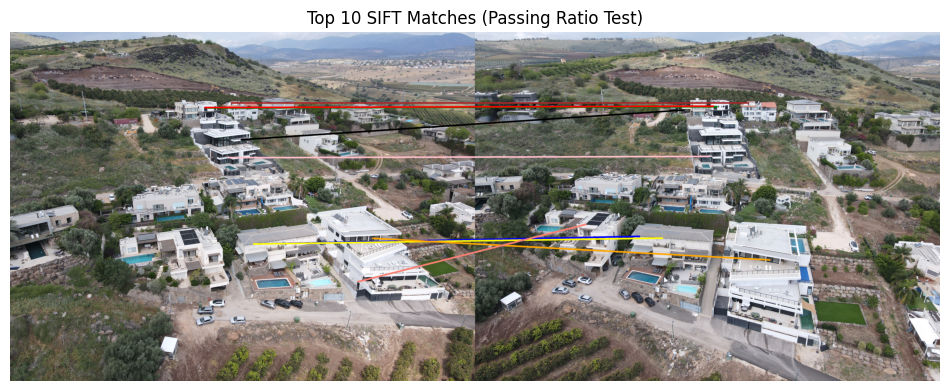

KNN distance calculations runtime: 0.092 seconds


In [ ]:
knn_time, knn_indices, knn_distances = siftKNN(migdal_1, migdal_2, migdal_1_img, migdal_2_img, threshold = 0.6)
print(f"KNN distance calculations runtime: {knn_time:.3f} seconds")

For threshold = 0.4:


Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0240
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1618.59, Y=1771.76
5. Distance: 0.0356
    Image 1 (train): X=1903.94, Y=610.04
    Image 2 (query): X=2352.27, Y=609.78
6. Distance: 0.0526
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
7. Distance: 0.0534
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
8. Distance: 0.0606
    Image 1 (train): X=1722.34, Y=2475.36
    Image 2 (query): X=754.44, Y=2226.83
9. Distance: 0.0606
    Image 1 (train): X=3422.58, Y=2194.62
    Image 2 (query): X=2561.03, Y=2483.68
10. Distance: 0.0619
    Image 1 (train): X=1479.83, Y

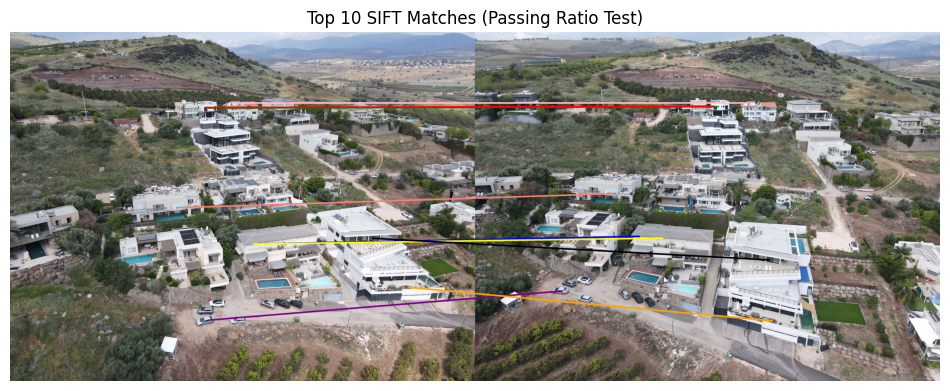

KNN distance calculations runtime: 0.134 seconds


In [ ]:
knn_time, knn_indices, knn_distances = siftKNN(migdal_1, migdal_2, migdal_1_img, migdal_2_img, threshold = 0.4)
print(f"KNN distance calculations runtime: {knn_time:.3f} seconds")

## Part C: ANN Models + Grid Search

### Average Distance Ratio Error

In [ ]:
def average_distance_ratio_error(ann_distances):
  quotient = np.divide(ann_distances, knn_distances)
  epsilon = np.mean(quotient) - 1
  return epsilon

### RKDT

In [ ]:
def sift_rkdt(df_1, df_2, n0, l0, threshold = 0.8, k=2):

    # Extract and normalize features (columns 5 to 132 inclusive = 128 dims)
    X_train = normalizeFeatures(df_1.iloc[:, 5:133].values)
    X_test = normalizeFeatures(df_2.iloc[:, 5:133].values)

    # Fit RKDT_ANN
    start_time = time.time()
    model = RKDT_ANN(N0=n0, L0=l0)
    model.fit(X_train)
    end_time = time.time()

    runtime = end_time - start_time

    # Query all keypoints in df_2
    indices, distances = model.kneighbors(X_test, k=k)

    filtered_indices = ratioTest(indices, distances, threshold)

    return runtime, filtered_indices, distances


ANN RKDT runtime for K = 1, L = 1: 0.045 seconds
ANN RKDT runtime for K = 1, L = 3: 0.122 seconds
ANN RKDT runtime for K = 5, L = 1: 0.011 seconds
ANN RKDT runtime for K = 5, L = 3: 0.033 seconds
ANN RKDT runtime for K = 5, L = 5: 0.071 seconds
ANN RKDT runtime for K = 10, L = 3: 0.017 seconds
ANN RKDT runtime for K = 10, L = 5: 0.031 seconds
ANN RKDT runtime for K = 20, L = 3: 0.010 seconds
ANN RKDT runtime for K = 20, L = 5: 0.015 seconds
ANN RKDT runtime for K = 20, L = 8: 0.024 seconds
ANN RKDT runtime for K = 40, L = 3: 0.007 seconds
ANN RKDT runtime for K = 40, L = 5: 0.011 seconds
ANN RKDT runtime for K = 40, L = 8: 0.019 seconds
For N0 = 40 and L0 = 8 the minimun error value of: 0.215


Data Summary:

    N0  L0  Runtime (s)     Error
0    1   1     0.045362       inf
1    1   3     0.121792  1.813324
2    5   1     0.011032  2.298228
3    5   3     0.033095  0.929830
4    5   5     0.071251  0.662846
5   10   3     0.016895  0.767604
6   10   5     0.031130  0.497317
7   20   

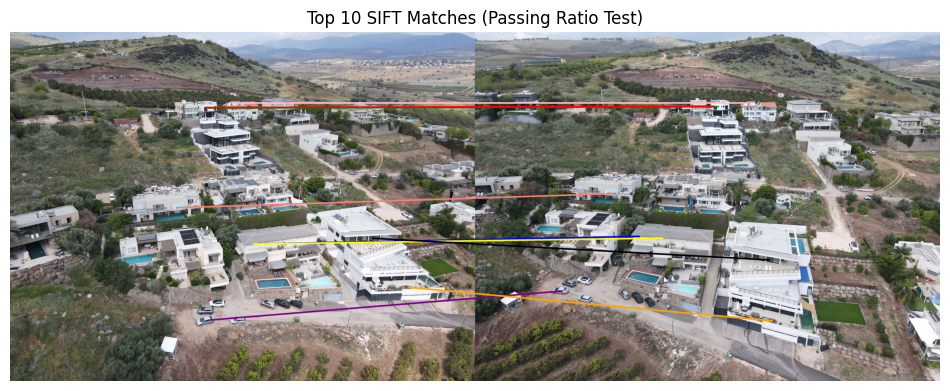

In [ ]:
n0_l0 = [[1, 1, 5, 5, 5, 10, 10, 20, 20, 20, 40, 40, 40], [1, 3, 1, 3, 5, 3, 5, 3, 5, 8, 3, 5, 8]]

ann_rkdt_error_values = []
ann_rkdt_runtime = []

for row in range(len(n0_l0[1])):
  runtime, filtered_indices, distances = sift_rkdt(migdal_1, migdal_2, n0_l0[0][row], n0_l0[1][row], 0.4, 2)
  print(f"ANN RKDT runtime for K = {n0_l0[0][row]}, L = {n0_l0[1][row]}: {runtime:.3f} seconds")
  ann_rkdt_runtime.append(runtime)
  ann_rkdt_error_values.append(average_distance_ratio_error(distances))

ann_rkdt_min_error_values = np.min(ann_rkdt_error_values)
min_error_index = np.argmin(ann_rkdt_error_values)

ann_rkdt_n0 = n0_l0[0][min_error_index]
ann_rkdt_l0 = n0_l0[1][min_error_index]

print (f'For N0 = {ann_rkdt_n0} and L0 = {ann_rkdt_l0} the minimun error value of: {ann_rkdt_min_error_values:.3f}')

data = {
    'N0': n0_l0[0],
    'L0': n0_l0[1],
    'Runtime (s)': ann_rkdt_runtime,
    'Error': ann_rkdt_error_values
}

df = pd.DataFrame(data)

print('\n')
print('Data Summary:\n')
print(df)

runtime, filtered_indices, ann_rkdt_distances = sift_rkdt(migdal_1, migdal_2, ann_rkdt_n0, ann_rkdt_l0, 0.4, 2)

print('\n\n')
print('Visualization for the best K and L values:')

# Visualize
visualizeSIFT(migdal_1, migdal_2, migdal_1_img, migdal_2_img, filtered_indices, ann_rkdt_distances, top_k=10)


We can see one wrong point in the best 10 matches

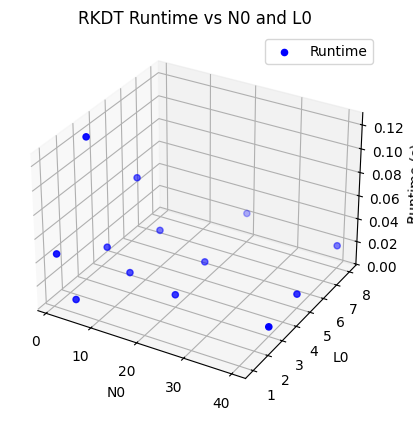

In [ ]:
# K and L values affect on runtime
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.scatter(n0_l0[0], n0_l0[1], ann_rkdt_runtime, c='blue', label='Runtime')
ax.set_xlabel("N0")
ax.set_ylabel("L0")
ax.set_zlabel("Runtime (s)")
ax.set_title("RKDT Runtime vs N0 and L0")
plt.legend()
plt.show()

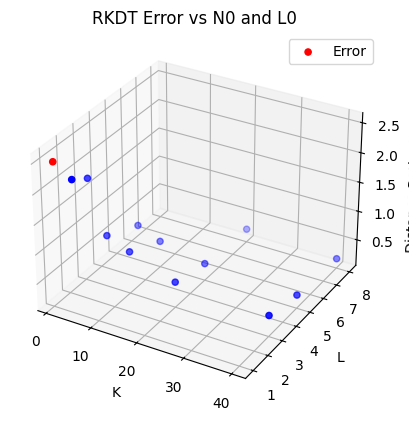

k: [1, 1, 5, 5, 5, 10, 10, 20, 20, 20, 40, 40, 40]
l: [1, 3, 1, 3, 5, 3, 5, 3, 5, 8, 3, 5, 8]
error: [np.float64(inf), np.float64(1.8133242307807969), np.float64(2.29822780527556), np.float64(0.9298301778468421), np.float64(0.662845661920267), np.float64(0.7676042076196696), np.float64(0.4973170329983654), np.float64(0.4844502970813811), np.float64(0.34137802990507415), np.float64(0.275388147205194), np.float64(0.40911512657438864), np.float64(0.2779565994573576), np.float64(0.21466507366782017)]


In [ ]:
# K and L values affect on error
fig = plt.figure()
ax = plt.axes(projection ='3d')

# Cap inf errors to a visible high value  - 2.5 in this case
capped_error = np.where(np.isinf(ann_rkdt_error_values), 2.5, ann_rkdt_error_values)

# Set color: red if error was inf, blue otherwise
colors = ['red' if np.isinf(e) else 'blue' for e in ann_rkdt_error_values]

ax.scatter(n0_l0[0], n0_l0[1], capped_error, c=colors, label='Error')
ax.set_xlabel("K")
ax.set_ylabel("L")
ax.set_zlabel("Distance Ratio Error")
ax.set_title("RKDT Error vs N0 and L0")
plt.legend()
plt.show()

print(f'k: {n0_l0[0]}')
print(f'l: {n0_l0[1]}')
print(f'error: {ann_rkdt_error_values}')

### LSH

In [ ]:
def sift_lsh(df_1, df_2, k, l, threshold = 0.8):

    # Extract and normalize features (columns 5 to 132 inclusive = 128 dims)
    X_train = normalizeFeatures(df_1.iloc[:, 5:133].values)
    X_test = normalizeFeatures(df_2.iloc[:, 5:133].values)

    # Fit LSH_ANN
    start_time = time.time()
    model = LSH_ANN(K=k, L=l)
    model.fit(X_train)
    end_time = time.time()

    runtime = end_time - start_time

    # Query all keypoints in df_2
    indices, distances = model.kneighbors(X_test, k=2)

    filtered_indices = ratioTest(indices, distances, threshold)

    return runtime, filtered_indices, distances



ANN LSH runtime for K = 5, L = 2: 0.008 seconds
ANN LSH runtime for K = 5, L = 4: 0.013 seconds
ANN LSH runtime for K = 5, L = 8: 0.026 seconds
ANN LSH runtime for K = 10, L = 2: 0.011 seconds
ANN LSH runtime for K = 10, L = 4: 0.020 seconds
ANN LSH runtime for K = 10, L = 8: 0.046 seconds
ANN LSH runtime for K = 12, L = 4: 0.022 seconds
ANN LSH runtime for K = 12, L = 8: 0.046 seconds


<ipython-input-114-61156885b3df>:22: RuntimeWarning: invalid value encountered in divide
  ratios = distances[:, 0] / (distances[:, 1] + 1e-8)


ANN LSH runtime for K = 15, L = 4: 0.034 seconds
ANN LSH runtime for K = 15, L = 8: 0.098 seconds
For K = 5 and L = 8 the minimun error value of: 0.145


Data Summary:

    K  L  Runtime (s)     Error
0   5  2     0.008132  0.187345
1   5  4     0.012733  0.150159
2   5  8     0.025617  0.144826
3  10  2     0.010927  0.237340
4  10  4     0.019741  0.236152
5  10  8     0.046087  0.151091
6  12  4     0.022476  0.240643
7  12  8     0.045564  0.149697
8  15  4     0.033540       inf
9  15  8     0.097648  0.175572



Visualization for the best K and L values:

Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0240
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1618.59, Y=1771.76
5. D

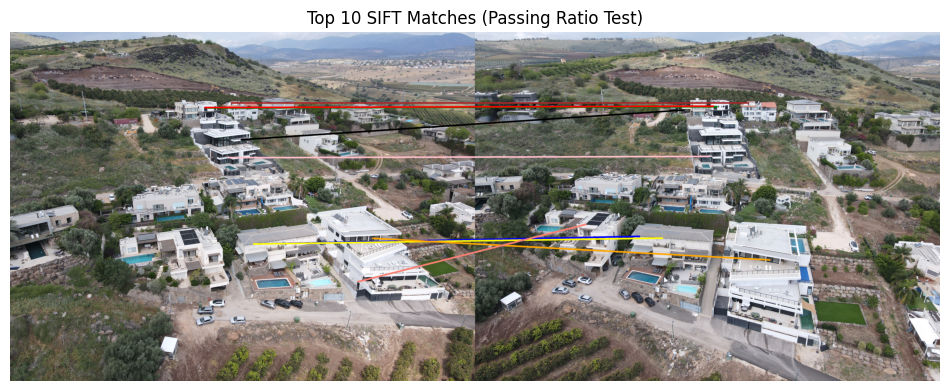

In [ ]:
k_l = [[5, 5, 5, 10, 10, 10, 12, 12, 15, 15], [2, 4, 8, 2, 4, 8, 4, 8, 4, 8]]

ann_lsh_error_values = []
ann_lsh_runtime = []

for row in range(len(k_l[1])):
  runtime, filtered_indices, distances = sift_lsh(migdal_1, migdal_2, k_l[0][row], k_l[1][row], 0.6)
  print(f"ANN LSH runtime for K = {k_l[0][row]}, L = {k_l[1][row]}: {runtime:.3f} seconds")
  ann_lsh_runtime.append(runtime)
  ann_lsh_error_values.append(average_distance_ratio_error(distances))

ann_lsh_min_error_value = np.min(ann_lsh_error_values)
min_error_index = np.argmin(ann_lsh_error_values)

ann_lsh_k = k_l[0][min_error_index]
ann_lsh_l = k_l[1][min_error_index]

print (f'For K = {ann_lsh_k} and L = {ann_lsh_l} the minimun error value of: {ann_lsh_min_error_value:.3f}')

data = {
    'K': k_l[0],
    'L': k_l[1],
    'Runtime (s)': ann_lsh_runtime,
    'Error': ann_lsh_error_values
}

df = pd.DataFrame(data)

print('\n')
print('Data Summary:\n')
print(df)

runtime, filtered_indices, ann_lsh_distances = sift_lsh(migdal_1, migdal_2, ann_lsh_k, ann_lsh_l, 0.6)

print('\n\n')
print('Visualization for the best K and L values:')

visualizeSIFT(migdal_1, migdal_2, migdal_1_img, migdal_2_img, filtered_indices, ann_lsh_distances, top_k=10)

We can see that in the best 10 matches there's only 1 wrong point



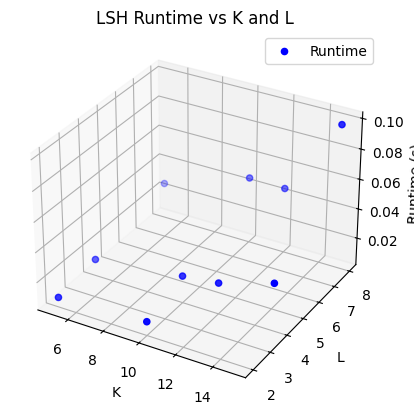

In [ ]:
# K and L values affect on runtime
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.scatter(k_l[0], k_l[1], ann_lsh_runtime, c='blue', label='Runtime')
ax.set_xlabel("K")
ax.set_ylabel("L")
ax.set_zlabel("Runtime (s)")
ax.set_title("LSH Runtime vs K and L")
plt.legend()
plt.show()

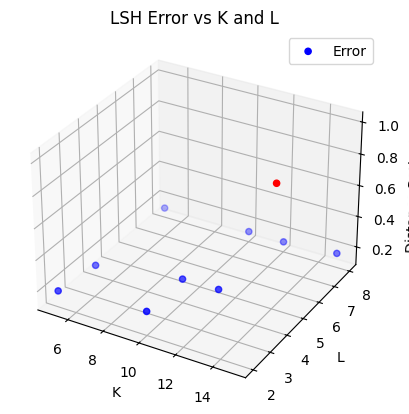

k: [5, 5, 5, 10, 10, 10, 12, 12, 15, 15]
l: [2, 4, 8, 2, 4, 8, 4, 8, 4, 8]
error: [np.float64(0.187345227852997), np.float64(0.15015857215867467), np.float64(0.14482609676871072), np.float64(0.23733996837437532), np.float64(0.23615230262488818), np.float64(0.15109086591082455), np.float64(0.2406426619772919), np.float64(0.1496965795266969), np.float64(inf), np.float64(0.17557242604229018)]


In [ ]:
# K and L values affect on error
fig = plt.figure()
ax = plt.axes(projection ='3d')

# Cap inf errors to a visible high value  - 1 in this case
capped_error = np.where(np.isinf(ann_lsh_error_values), 1, ann_lsh_error_values)

# Set color: red if error was inf, blue otherwise
colors = ['red' if np.isinf(e) else 'blue' for e in ann_lsh_error_values]

ax.scatter(k_l[0], k_l[1], capped_error, c=colors, label='Error')
ax.set_xlabel("K")
ax.set_ylabel("L")
ax.set_zlabel("Distance Ratio Error")
ax.set_title("LSH Error vs K and L")
plt.legend()
plt.show()

print(f'k: {k_l[0]}')
print(f'l: {k_l[1]}')
print(f'error: {ann_lsh_error_values}')

## Part D: Compare with sklearn Nearest Neighbors

In [ ]:
desc_A = migdal_1.iloc[:, 5:].values.astype(np.float32)
desc_B = migdal_2.iloc[:, 5:].values.astype(np.float32)

# Initialize model with KDTree backend
knn = NearestNeighbors(n_neighbors=2, algorithm='kd_tree')

# Fit on descriptors from image A
start_sklearn_train = time.time()
knn.fit(desc_A)
end_sklearn_train = time.time()

sklearn_time = end_sklearn_train - start_sklearn_train

# Query descriptors from image B
start_sklearn_query = time.time()
sklearn_distances, indices = knn.kneighbors(desc_B)
end_sklearn_query = time.time()

In [ ]:
# Use a threshold (e.g. 0.8)
threshold = 0.8
ratios = sklearn_distances[:, 0] / sklearn_distances[:, 1]
valid_matches = np.where(ratios < threshold)[0]

# Number of matches
num_valid = len(valid_matches)
print(f"Valid matches (ratio < {threshold}): {num_valid} / {len(desc_B)}")

Valid matches (ratio < 0.8): 89 / 1000


### comparison plots

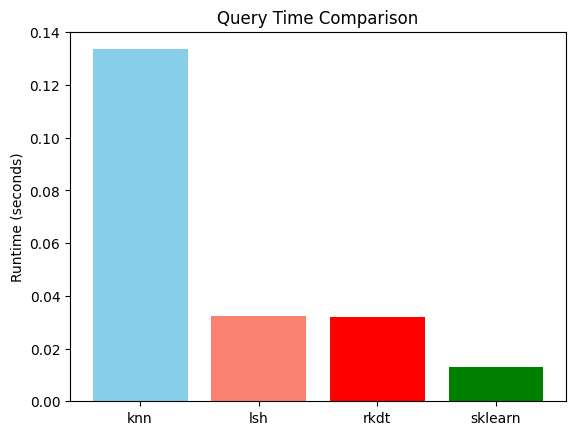

In [ ]:
#Runtime comparison

plt.bar(["knn", "lsh", "rkdt", "sklearn"], [knn_time, np.mean(ann_lsh_runtime),
        np.mean(ann_rkdt_runtime), sklearn_time], color=['skyblue', 'salmon', 'red', 'green'])
plt.ylabel('Runtime (seconds)')
plt.title('Query Time Comparison')
plt.show()

In [ ]:
# error calc compared to sklearn
def average_distance_ratio_error_sklearn(distances):
  quotient = np.divide(distances, knn_distances)
  epsilon = np.mean(quotient) - 1
  return epsilon

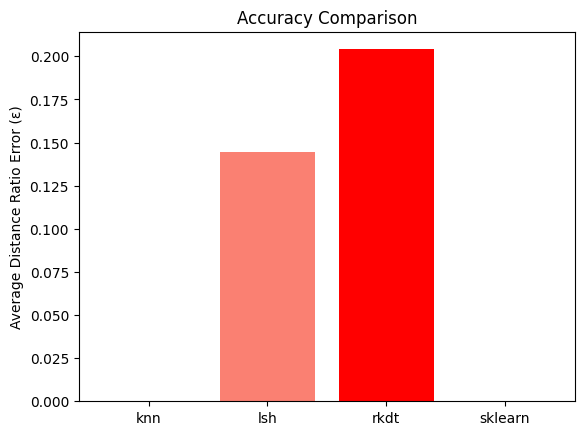

In [ ]:
# Accuracy comparison

# calculating the errors of all algoritms compared to sklearn
knn_sk_error = average_distance_ratio_error_sklearn(knn_distances)
ann_lsh_sk_error = average_distance_ratio_error_sklearn(ann_lsh_distances)
ann_rkdt_sk_error = average_distance_ratio_error_sklearn(ann_rkdt_distances)

# displaying all errors with sklearn as baseline

plt.bar(["knn", "lsh", "rkdt", "sklearn"], [knn_sk_error, ann_lsh_sk_error,
        ann_rkdt_sk_error, 0], color=['skyblue', 'salmon', 'red', 'green'])
plt.ylabel('Average Distance Ratio Error (ε)')
plt.title('Accuracy Comparison')
plt.show()

## Part E: Place Recognition

In [ ]:
X_train, y_train = load_training_data()

rkdt = RKDT_ANN(N0=40, L0=8)
rkdt.fit(X_train)
rkdt.labels = y_train


In [ ]:

for filename in os.listdir():
  if filename.endswith("_2_sift_dataset.csv") or filename == "migdal_2_sift_dataset.csv":
    print(f"\nTesting: {filename}")
    df_test = pd.read_csv(filename)
    X_test = normalizeFeatures(df_test.iloc[:, 5:133].values)

    label, confidence = rkdt.predict(X_test, k=1, distance_threshold=0.5, confidence_cutoff = 0.18)

    print("Prediction:", label)
    print("Confidence:", round(confidence, 2))



Testing: migdal_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.14

Testing: mount_fuji_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.15

Testing: colosseum_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.13

Testing: taj_mahal_2_sift_dataset.csv
Prediction: taj_mahal
Confidence: 0.19

Testing: christ_the_redeemer_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.12

Testing: azrieli_towers_2_sift_dataset.csv
Prediction: azrieli_towers
Confidence: 0.89

Testing: sydney_opera_house_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.14

Testing: petra_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.17

Testing: mount_rushmore_2_sift_dataset.csv
Prediction: mount_rushmore
Confidence: 0.18

Testing: statue_of_liberty_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.13

Testing: pyramids_of_giza_2_sift_dataset.csv
Prediction: No

In [ ]:
X_train, y_train = load_training_data()

lsh = LSH_ANN(K=5, L=10)
lsh.fit(X_train)
lsh.labels = y_train


In [ ]:

for filename in os.listdir():
  if filename.endswith("_2_sift_dataset.csv") or filename == "migdal_2_sift_dataset.csv":
    print(f"\nTesting: {filename}")
    df_test = pd.read_csv(filename)
    X_test = normalizeFeatures(df_test.iloc[:, 5:133].values)

    label, confidence = lsh.predict(X_test, k=3, distance_threshold=0.2, confidence_cutoff = 0.19)


    print("Prediction:", label)
    print("Confidence:", round(confidence, 2))



Testing: migdal_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.17

Testing: mount_fuji_2_sift_dataset.csv
Prediction: mount_fuji
Confidence: 0.3

Testing: colosseum_2_sift_dataset.csv
Prediction: colosseum
Confidence: 0.3

Testing: taj_mahal_2_sift_dataset.csv
Prediction: taj_mahal
Confidence: 0.33

Testing: christ_the_redeemer_2_sift_dataset.csv
Prediction: taj_mahal
Confidence: 0.29

Testing: azrieli_towers_2_sift_dataset.csv
Prediction: azrieli_towers
Confidence: 0.98

Testing: sydney_opera_house_2_sift_dataset.csv
Prediction: No matching landmark found
Confidence: 0.17

Testing: petra_2_sift_dataset.csv
Prediction: pyramids_of_giza
Confidence: 0.36

Testing: mount_rushmore_2_sift_dataset.csv
Prediction: mount_rushmore
Confidence: 0.21

Testing: statue_of_liberty_2_sift_dataset.csv
Prediction: taj_mahal
Confidence: 0.2

Testing: pyramids_of_giza_2_sift_dataset.csv
Prediction: taj_mahal
Confidence: 0.4

Testing: stonehenge_2_sift_dataset.csv
Prediction: ston

In [ ]:
true_label_map = {
    "eiffel_tower_2_sift_dataset.csv": "eiffel_tower",
    "statue_of_liberty_2_sift_dataset.csv": "statue_of_liberty",
    "taj_mahal_2_sift_dataset.csv": "taj_mahal",
    "notre_dame_2_sift_dataset.csv": "notre_dame",
    "colosseum_2_sift_dataset.csv": "colosseum",
    "mount_rushmore_2_sift_dataset.csv": "mount_rushmore",
    "golden_gate_bridge_2_sift_dataset.csv": "golden_gate_bridge",
    "sydney_opera_house_2_sift_dataset.csv": "sydney_opera_house",
    "pyramids_2_sift_dataset.csv": "pyramids",
    "big_ben_2_sift_dataset.csv": "big_ben",
    "machu_picchu_2_sift_dataset.csv": "machu_picchu",
    "azrieli_towers_2_sift_dataset.csv": "azrieli_towers",
    "christ_the_redeemer_2_sift_dataset.csv": "christ_the_redeemer",
    "mount_fuji_2_sift_dataset.csv": "mount_fuji",
    "petra_2_sift_dataset.csv": "petra",
    "pyramids_of_giza_2_sift_dataset.csv": "pyramids_of_giza",
    "stonehenge_2_sift_dataset.csv": "stonehenge",
    "migdal_2_sift_dataset.csv": "no match"
}

# Containers for metrics
true_labels = []
rkdt_preds = []
lsh_preds = []
rkdt_confs = []
lsh_confs = []

# Evaluation loop
for filename in sorted(os.listdir()):
    if filename.endswith("_2_sift_dataset.csv") or filename == "migdal_2_sift_dataset.csv":
        print(f"\n Testing: {filename}")
        df = pd.read_csv(filename)
        X_test = normalizeFeatures(df.iloc[:, 5:133].values)
        true_label = true_label_map[filename]

        # 🔹 RKDT Prediction
        rkdt_label, rkdt_conf = rkdt.predict(X_test, k=1, distance_threshold=0.5, confidence_cutoff=0.18)
        rkdt_preds.append(rkdt_label)
        rkdt_confs.append(rkdt_conf)

        # 🔹 LSH Prediction
        lsh_label, lsh_conf = lsh.predict(X_test, k=3, distance_threshold=0.2, confidence_cutoff=0.19)
        lsh_preds.append(lsh_label)
        lsh_confs.append(lsh_conf)

        # 🔹 Ground truth
        true_labels.append(true_label)

        print(f"  True: {true_label}")
        print(f"  RKDT → {rkdt_label:25} | Conf: {rkdt_conf:.2f}")
        print(f"  LSH  → {lsh_label:25} | Conf: {lsh_conf:.2f}")


 Testing: azrieli_towers_2_sift_dataset.csv
  True: azrieli_towers
  RKDT → azrieli_towers            | Conf: 0.89
  LSH  → azrieli_towers            | Conf: 0.98

 Testing: christ_the_redeemer_2_sift_dataset.csv
  True: christ_the_redeemer
  RKDT → No matching landmark found | Conf: 0.12
  LSH  → taj_mahal                 | Conf: 0.29

 Testing: colosseum_2_sift_dataset.csv
  True: colosseum
  RKDT → No matching landmark found | Conf: 0.13
  LSH  → colosseum                 | Conf: 0.30

 Testing: migdal_2_sift_dataset.csv
  True: no match
  RKDT → No matching landmark found | Conf: 0.14
  LSH  → No matching landmark found | Conf: 0.17

 Testing: mount_fuji_2_sift_dataset.csv
  True: mount_fuji
  RKDT → No matching landmark found | Conf: 0.15
  LSH  → mount_fuji                | Conf: 0.30

 Testing: mount_rushmore_2_sift_dataset.csv
  True: mount_rushmore
  RKDT → mount_rushmore            | Conf: 0.18
  LSH  → mount_rushmore            | Conf: 0.21

 Testing: petra_2_sift_dataset.c

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

all_classes = sorted(set(true_labels + rkdt_preds + lsh_preds))

print("\n RKDT Accuracy:", round(accuracy_score(true_labels, rkdt_preds) * 100, 2), "%")
print("RKDT Macro F1 Score:", round(f1_score(true_labels, rkdt_preds, average='macro', zero_division=0), 2))

print("\n LSH Accuracy:", round(accuracy_score(true_labels, lsh_preds) * 100, 2), "%")
print("LSH Macro F1 Score:", round(f1_score(true_labels, lsh_preds, average='macro', zero_division=0), 2))

print("\n RKDT Confusion Matrix:")
print(confusion_matrix(true_labels, rkdt_preds, labels=all_classes))

print("\n LSH Confusion Matrix:")
print(confusion_matrix(true_labels, lsh_preds, labels=all_classes))



 RKDT Accuracy: 33.33 %
RKDT Macro F1 Score: 0.31

 LSH Accuracy: 50.0 %
LSH Macro F1 Score: 0.42

 RKDT Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]

 LSH Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [ ]:
# Example dummy values for the parameters, adjust as needed
k_values = [10] * len(true_labels)
l_values = [5] * len(true_labels)
l0_values = [3] * len(true_labels)
n0_values = [7] * len(true_labels)

print("\n Final Results Table:")
header = (
    f"{'Index':>5} | {'Test File':35} | {'True Label':20} | "
    f"{'RKDT':25} | {'LSH':25} | {'RKDT Conf':10} | {'LSH Conf':10} | "
    f"{'k':>3} | {'l':>3} | {'l0':>4} | {'n0':>4}"
)
print(header)
print("-" * len(header))

for i in range(len(true_labels)):
    print(
        f"{i:5} | {'(unknown filename)':35} | {true_labels[i]:20} | "
        f"{rkdt_preds[i]:25} | {lsh_preds[i]:25} | {rkdt_confs[i]:10.2f} | {lsh_confs[i]:10.2f} | "
        f"{k_values[i]:3} | {l_values[i]:3} | {l0_values[i]:4} | {n0_values[i]:4}"
    )



 Final Results Table:
Index | Test File                           | True Label           | RKDT                      | LSH                       | RKDT Conf  | LSH Conf   |   k |   l |   l0 |   n0
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    0 | (unknown filename)                  | azrieli_towers       | azrieli_towers            | azrieli_towers            |       0.89 |       0.98 |  10 |   5 |    3 |    7
    1 | (unknown filename)                  | christ_the_redeemer  | No matching landmark found | taj_mahal                 |       0.12 |       0.29 |  10 |   5 |    3 |    7
    2 | (unknown filename)                  | colosseum            | No matching landmark found | colosseum                 |       0.13 |       0.30 |  10 |   5 |    3 |    7
    3 | (unknown filename)                  | no match             | No matching landmark found | No

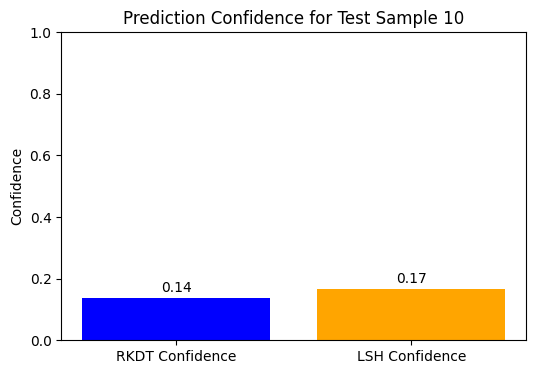

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confidences(index):
    labels = ['RKDT Confidence', 'LSH Confidence']
    confidences = [rkdt_confs[index], lsh_confs[index]]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, confidences, color=['blue', 'orange'])
    plt.ylim(0, 1)  # assuming confidence values between 0 and 1

    # Add confidence values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

    plt.title(f"Prediction Confidence for Test Sample {index}")
    plt.ylabel("Confidence")
    plt.show()

# Example: plot confidence for test sample 0
plot_confidences(10)
